In [27]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('world_real_estate_data(147k).csv')

print("First 5 rows of the dataset:")
display(df.head())

print("\nDataFrame information:")
df.info()

First 5 rows of the dataset:


,title,country,location,building_construction_year,building_total_floors,apartment_floor,apartment_rooms,apartment_bedrooms,apartment_bathrooms,apartment_total_area,apartment_living_area,price_in_USD,image,url
0,2 room apartment 120 m² in Mediterranean Regio...,Turkey,"Mediterranean Region, Turkey",NaN,5.0,1.0,3.0,2.0,2.0,120 m²,110 m²,315209.0,https://realting.com/uploads/bigSlider/ab3/888...,https://realting.com/property-for-sale/turkey/...
1,"4 room villa 500 m² in Kalkan, Turkey",Turkey,"Kalkan, Mediterranean Region, Kas, Turkey",2021.0,2.0,NaN,NaN,NaN,NaN,500 m²,480 m²,1108667.0,https://realting.com/uploads/bigSlider/87b/679...,https://realting.com/property-for-sale/turkey/...
2,"1 room apartment 65 m² in Antalya, Turkey",Turkey,"Mediterranean Region, Antalya, Turkey",NaN,5.0,2.0,2.0,1.0,1.0,65 m²,60 m²,173211.0,https://realting.com/uploads/bigSlider/030/a11...,https://realting.com/property-for-sale/turkey/...
3,"1 room apartment in Pattaya, Thailand",Thailand,"Chon Buri Province, Pattaya, Thailand",2020.0,15.0,5.0,2.0,1.0,1.0,NaN,40 m²,99900.0,https://realting.com/uploads/bigSlider/e9a/e06...,https://realting.com/property-for-sale/thailan...
4,"2 room apartment in Pattaya, Thailand",Thailand,"Chon Buri Province, Pattaya, Thailand",2026.0,8.0,3.0,3.0,2.0,1.0,NaN,36 m²,67000.0,https://realting.com/uploads/bigSlider/453/aa2...,https://realting.com/property-for-sale/thailan...



DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147536 entries, 0 to 147535
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   title                       147536 non-null  object 
 1   country                     147406 non-null  object 
 2   location                    147405 non-null  object 
 3   building_construction_year  64719 non-null   float64
 4   building_total_floors       68224 non-null   float64
 5   apartment_floor             54592 non-null   float64
 6   apartment_rooms             74178 non-null   float64
 7   apartment_bedrooms          36982 non-null   float64
 8   apartment_bathrooms         55973 non-null   float64
 9   apartment_total_area        141796 non-null  object 
 10  apartment_living_area       27712 non-null   object 
 11  price_in_USD                144961 non-null  float64
 12  image                       147536 non-null  obj

In [28]:
df.isnull().sum()


title                              0
country                          130
location                         131
building_construction_year     82817
building_total_floors          79312
apartment_floor                92944
apartment_rooms                73358
apartment_bedrooms            110554
apartment_bathrooms            91563
apartment_total_area            5740
apartment_living_area         119824
price_in_USD                    2575
image                              0
url                                0
dtype: int64

In [29]:
import re

# Drop columns that are not useful for a price prediction model
df = df.drop(columns=['title', 'location', 'image', 'url'])

# Drop rows where the target variable 'price_in_USD' is missing
df = df.dropna(subset=['price_in_USD'])

# Clean and convert 'apartment_total_area' and 'apartment_living_area' columns
def clean_area(area):
    if isinstance(area, str):
        
        
        cleaned_area = re.sub(r'[^\d.]', '', area)
        if cleaned_area:
            return float(cleaned_area)
    return area

df['apartment_total_area'] = df['apartment_total_area'].apply(clean_area)
df['apartment_living_area'] = df['apartment_living_area'].apply(clean_area)

# Create a new feature: Price Per Square Meter
df['price_per_sqm'] = df['price_in_USD'] / df['apartment_total_area']

current_year = 2025  

# Create a new feature: Building Age
df['building_age'] = current_year - df['building_construction_year']

# Handle cases where the construction year is in the future
df['building_age'] = df['building_age'].apply(lambda x: 0 if x < 0 else x)

# Create a new feature: Total Rooms
df['total_rooms'] = df['apartment_bedrooms'] + df['apartment_bathrooms']

# Fill remaining missing numerical values with the median
numerical_cols = ['building_construction_year', 'building_total_floors', 'apartment_floor', 'apartment_rooms',
                  'apartment_bedrooms', 'apartment_bathrooms', 'apartment_total_area', 'apartment_living_area',
                  'total_rooms','building_age','price_per_sqm']

for col in numerical_cols:
    # This is the updated line to avoid the warning:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values in 'country' with the mode

df['country'] = df['country'].fillna(df['country'].mode()[0])

# One-hot encode the 'country' column
df = pd.get_dummies(df, columns=['country'], drop_first=True)

In [30]:
df.head(5)

,building_construction_year,building_total_floors,apartment_floor,apartment_rooms,apartment_bedrooms,apartment_bathrooms,apartment_total_area,apartment_living_area,price_in_USD,price_per_sqm,...,country_Poland,country_Portugal,country_Russia,country_Serbia,country_Spain,country_Thailand,country_Turkey,country_UAE,country_United States,country_Uzbekistan
0,2021.0,5.0,1.0,3.0,2.0,2.0,120.0,110.0,315209.0,2626.741667,...,False,False,False,False,False,False,True,False,False,False
1,2021.0,2.0,4.0,2.0,2.0,1.0,500.0,480.0,1108667.0,2217.334000,...,False,False,False,False,False,False,True,False,False,False
2,2021.0,5.0,2.0,2.0,1.0,1.0,65.0,60.0,173211.0,2664.784615,...,False,False,False,False,False,False,True,False,False,False
3,2020.0,15.0,5.0,2.0,1.0,1.0,88.0,40.0,99900.0,2311.538462,...,False,False,False,False,False,True,False,False,False,False
4,2026.0,8.0,3.0,3.0,2.0,1.0,88.0,36.0,67000.0,2311.538462,...,False,False,False,False,False,True,False,False,False,False


In [31]:
import joblib

# Assuming 'df' is the name of your final cleaned DataFrame
joblib.dump(df, 'df_sample.pkl')

['df_sample.pkl']

In [32]:


X = df.drop('price_in_USD', axis=1) 
y = df['price_in_USD']

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()


model.fit(X_train, y_train)

LinearRegression()

In [34]:

from sklearn.metrics import mean_absolute_error, r2_score
# Use the trained model to make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared ($R^2$): {r2}")

Mean Absolute Error (MAE): 305251.4072652236
R-squared ($R^2$): 0.16628663519347786


In [35]:

df_sample = df.sample(n=10000, random_state=42)

X = df_sample.drop('price_in_USD', axis=1)
y = df_sample['price_in_USD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest R-squared: {rf_r2}")

Random Forest MAE: 36107.227023703024
Random Forest R-squared: 0.9014850701740722


Top 10 most important features:
                       Feature  Importance
8                price_per_sqm    0.464357
6         apartment_total_area    0.427737
7        apartment_living_area    0.043618
31               country_Spain    0.018532
1        building_total_floors    0.013051
22               country_Italy    0.006330
5          apartment_bathrooms    0.006145
0   building_construction_year    0.003009
9                 building_age    0.002863
10                 total_rooms    0.002591


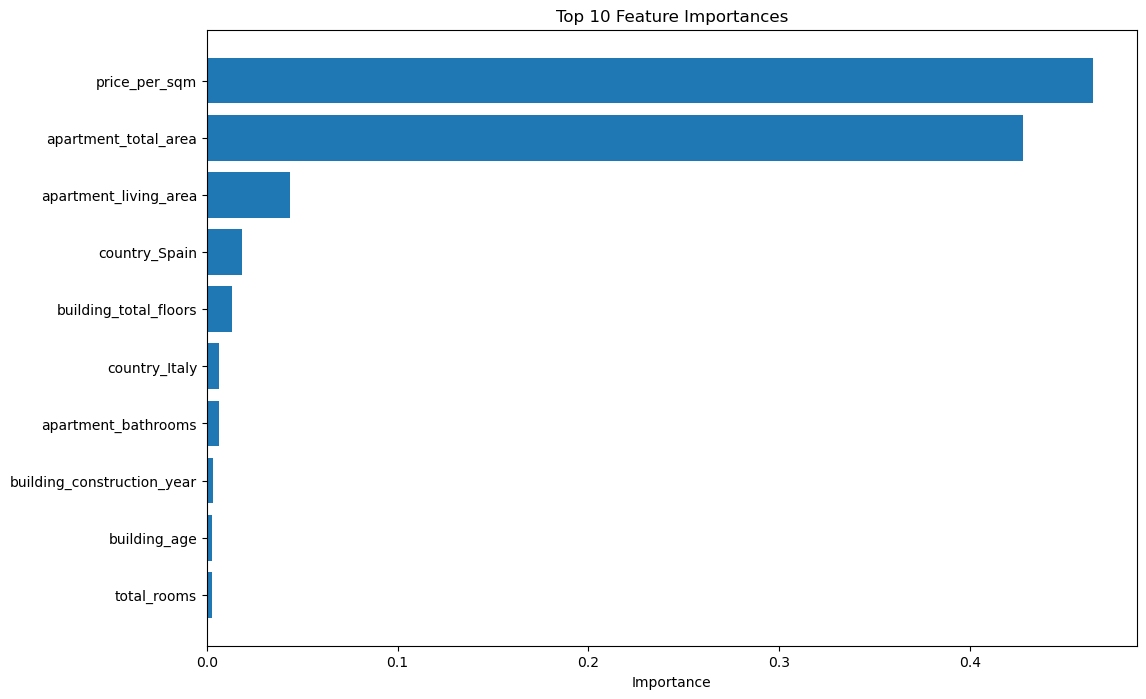

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_

feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 most important features:")
print(feature_importance_df.head(10))

# Visualize the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

In [37]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,  
                           n_jobs=-1,
                           scoring='r2')

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best R-squared score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best R-squared Score: {grid_search.best_score_}")

Best Parameters: {'max_depth': 30, 'n_estimators': 100}
Best R-squared Score: 0.839229071504897


In [38]:
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split



X = df.drop(['price_in_USD', 'price_per_sqm'], axis=1)
y = df['price_in_USD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_model = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
final_model.fit(X_train, y_train)



RandomForestRegressor(max_depth=30, random_state=42)

In [39]:
# Save the new, corrected model and feature names
import joblib
joblib.dump(final_model, 'final_real_estate_model_corrected.pkl')
joblib.dump(X.columns, 'feature_names_corrected.pkl')

['feature_names_corrected.pkl']